In [14]:
import pandas as pd
from pathlib import Path

base_folder = Path(r"C:\Users\au585732\OneDrive - Aarhus universitet\Thesis\Datasets\SampleWithWindowDataset")

sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']
data = {}

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    data[folder.name] = {}
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')  # handles BOM if present
            # Normalize column names: strip spaces and BOM, unify case
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder.name][sample_file] = df



In [15]:
import pandas as pd
from pathlib import Path

base_folder = Path(r"C:\Users\au585732\OneDrive - Aarhus universitet\Thesis\Datasets\SampleWithWindowDataset")
sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']

# Containers for data and weights
data = {}
weights = {}

# Helper function to read weights.txt into a dictionary
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# First, load healthy dataset weights for delta comparison
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Now process all folders
for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    data[folder_name] = {}
    weights[folder_name] = {}
    
    # Read weights
    weight_file = folder / "weights.txt"
    if weight_file.exists():
        current_weights = read_weights(weight_file)
        for sample_file in sample_files:
            if sample_file in current_weights:
                delta = current_weights[sample_file] - healthy_weights.get(sample_file, 0.0)
                weights[folder_name][sample_file] = delta
    
    # Read sample data
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder_name][sample_file] = df


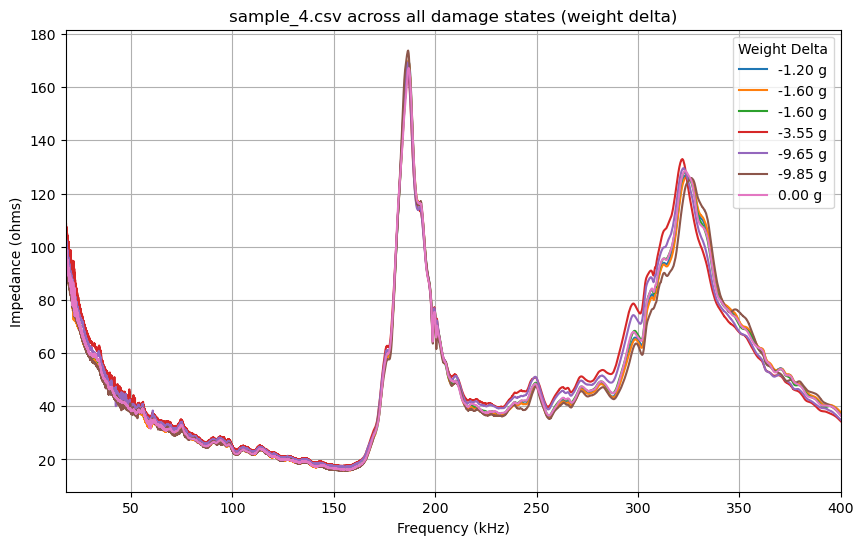

In [16]:
import matplotlib.pyplot as plt

sample_to_plot = "sample_4.csv"

plt.figure(figsize=(10, 6))

for folder_name, samples in data.items():
    if sample_to_plot in samples:
        df = samples[sample_to_plot]
        # Get the delta weight label, format nicely (e.g. 2 decimals)
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        label = f"{delta_weight:.2f} g" if delta_weight is not None else folder_name
        
        plt.plot(
            df["Frequency (Hz)"]/1000,
            df["Impedance (ohms)"],
            label=label
        )

plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance (ohms)")
plt.title(f"{sample_to_plot} across all damage states (weight delta)")
plt.legend(title="Weight Delta")
plt.grid(True)
plt.xlim(18,400)
plt.show()


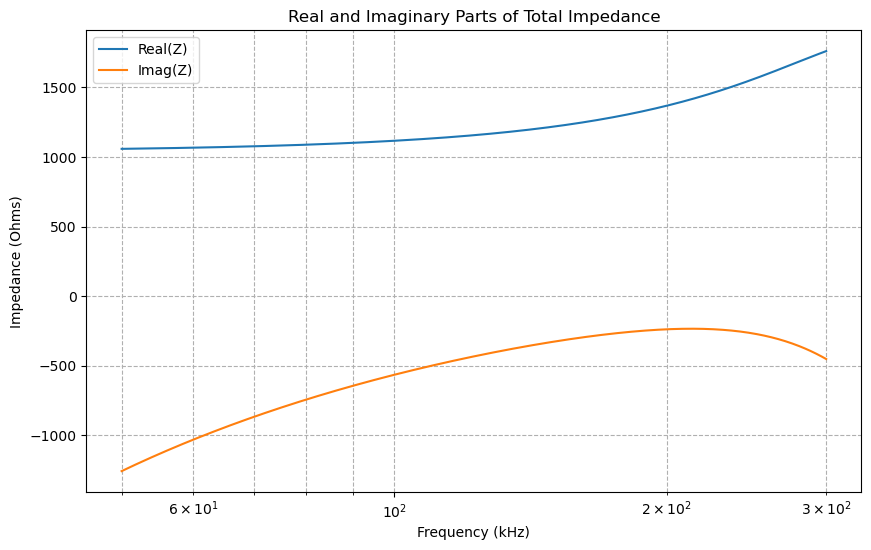

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Component values
C0 = 260.38e-12  # pFarads
L1 = 587.63e-6  # uHenrys
C1 = 2.18e-9  # nFarads
R1 = 1302     # Ohms

# Frequency range
start_freq = 50_000   # 50 kHz
end_freq = 300_000    # 400 kHz
num_points = 500

f = np.logspace(np.log10(start_freq), np.log10(end_freq), num_points)

omega = 2 * np.pi * f

# Impedances
Z_C0 = 1 / (1j * omega * C0)
Z_series = R1 + 1j * omega * L1 - 1j / (omega * C1)

# Total impedance of parallel combination
Z_total = 1 / (1 / Z_C0 + 1 / Z_series)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(f/1000, Z_total.real, label='Real(Z)')
plt.plot(f/1000, Z_total.imag, label='Imag(Z)')
plt.xscale('log')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Impedance (Ohms)')
plt.title('Real and Imaginary Parts of Total Impedance')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()


Fitted parameters (band):
C0 = 3.1305e-09 F
L1 = 2.8844e-03 H
C1 = 1.8709e-06 F
R1 = 36.4752 Ω


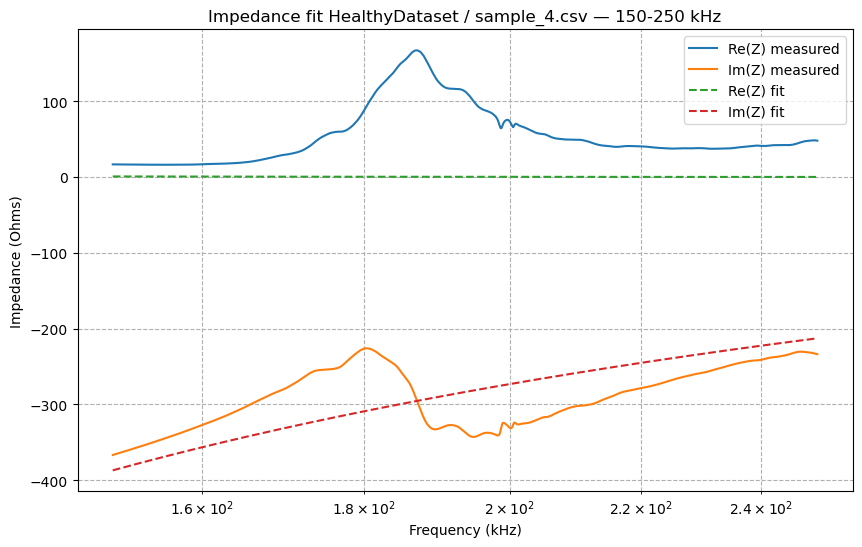

RMSE Real: 6.5563e+01 Ω
RMSE Imag: 4.2412e+01 Ω
R² Real: -2.2223
R² Imag: -0.1762


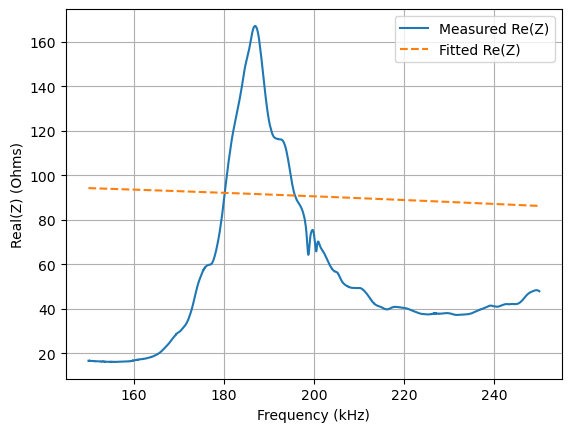

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# ----- Circuit model -----
def impedance_model(f, C0, L1, C1, R1):
    w = 2 * np.pi * f
    Z_C0 = 1.0 / (1j * w * C0)
    Z_series = R1 + 1j * w * L1 - 1j / (w * C1)
    Z_total = 1.0 / (1.0 / Z_C0 + 1.0 / Z_series)
    return Z_total

# ----- Residual builders -----
def residuals_complex(params, f, Z_meas, weights=None):
    Z_pred = impedance_model(f, *params)
    r = np.concatenate([(Z_pred.real - Z_meas.real), (Z_pred.imag - Z_meas.imag)])
    if weights is not None:
        r[:len(f)] *= weights
        r[len(f):] *= weights
    return r

def residuals_magnitude(params, f, Zmag_meas, weights=None):
    Z_pred = impedance_model(f, *params)
    r = np.abs(Z_pred) - Zmag_meas
    if weights is not None:
        r *= weights
    return r

# ----- Parse impedance from DF -----
def get_frequency_and_impedance(df):
    f = df["Frequency (Hz)"].to_numpy(dtype=float)
    Re = df["Impedance (ohms)"].to_numpy(dtype=float)  # Real part
    Im = df["Phase (Radians)"].to_numpy(dtype=float)   # Imaginary part (mislabeled)
    Z = Re + 1j * Im
    return f, Z, None

import numpy as np

def fit_quality_metrics(f, Z_meas, Z_fit):
    err_real = Z_fit.real - Z_meas.real
    err_imag = Z_fit.imag - Z_meas.imag
    
    rmse_real = np.sqrt(np.mean(err_real**2))
    rmse_imag = np.sqrt(np.mean(err_imag**2))
    
    print(f"RMSE Real: {rmse_real:.4e} Ω")
    print(f"RMSE Imag: {rmse_imag:.4e} Ω")

    # Optional: correlation coefficient (R²) for real and imag
    def r2(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        return 1 - ss_res/ss_tot
    
    r2_real = r2(Z_meas.real, Z_fit.real)
    r2_imag = r2(Z_meas.imag, Z_fit.imag)
    print(f"R² Real: {r2_real:.4f}")
    print(f"R² Imag: {r2_imag:.4f}")

def residuals_real(params, f, Z_meas_real, weights=None):
    Z_pred = impedance_model(f, *params)
    r = Z_pred.real - Z_meas_real
    if weights is not None:
        r *= weights
    return r

def fit_impedance_real(f, Z_meas_real, p0, bounds, weights=None, verbose=False):
    res = least_squares(
        residuals_real, x0=np.array(p0, dtype=float),
        bounds=bounds, args=(f, Z_meas_real, weights),
        jac="2-point", max_nfev=2000, xtol=1e-12, ftol=1e-12, gtol=1e-12,
        verbose=2 if verbose else 0
    )
    popt = res.x
    Z_fit = impedance_model(f, *popt)
    return popt, Z_fit, res



# ----- Fit one trace -----
def fit_impedance(f, Z_meas=None, Zmag_meas=None,
                  p0=(260.38e-12, 587.63e-6, 2.18e-9, 1302.0),
                  bounds=((1e-13, 1e-7, 1e-10, 1.0), (1e-9, 5e-3, 1e-6, 1e6)),
                  weights=None, verbose=False):
    if Z_meas is not None:
        res = least_squares(
            residuals_complex, x0=np.array(p0, dtype=float),
            bounds=bounds, args=(f, Z_meas, weights),
            jac="2-point", max_nfev=2000, xtol=1e-12, ftol=1e-12, gtol=1e-12,
            verbose=2 if verbose else 0
        )
    elif Zmag_meas is not None:
        res = least_squares(
            residuals_magnitude, x0=np.array(p0, dtype=float),
            bounds=bounds, args=(f, Zmag_meas, weights),
            jac="2-point", max_nfev=2000, xtol=1e-12, ftol=1e-12, gtol=1e-12,
            verbose=2 if verbose else 0
        )
    else:
        raise ValueError("Provide either Z_meas or Zmag_meas.")

    popt = res.x
    Z_fit = impedance_model(f, *popt)
    return popt, Z_fit, res

# ----- Plot helper -----
def plot_fit(f, Z_meas=None, Zmag_meas=None, Z_fit=None, title_suffix=""):
    plt.figure(figsize=(10, 6))
    plt.xscale("log")
    if Z_meas is not None:
        plt.plot(f/1e3, Z_meas.real, label="Re(Z) measured")
        plt.plot(f/1e3, Z_meas.imag, label="Im(Z) measured")
        if Z_fit is not None:
            plt.plot(f/1e3, Z_fit.real, '--', label="Re(Z) fit")
            plt.plot(f/1e3, Z_fit.imag, '--', label="Im(Z) fit")
        ylabel = "Impedance (Ohms)"
    else:
        plt.plot(f/1e3, Zmag_meas, label="|Z| measured")
        if Z_fit is not None:
            plt.plot(f/1e3, np.abs(Z_fit), '--', label="|Z| fit")
        ylabel = "|Z| (Ohms)"
    plt.xlabel("Frequency (kHz)")
    plt.ylabel(ylabel)
    plt.title(f"Impedance fit {title_suffix}")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

# ===== Example usage =====
folder_name = "HealthyDataset"
sample_to_fit = "sample_4.csv"
folder_key = folder_name  # adjust if you use safe lookup

df = data[folder_key][sample_to_fit]
f, Z_meas, Zmag_meas = get_frequency_and_impedance(df)

# ---- Parameters & band selection ----
p0 = (250e-12, 500e-6, 2e-9, 1000.0)
bounds = ((1e-15, 1e-9, 1e-12, 1e-3),
          (1e-6, 1e-2, 1e-4, 1e8))
w = None

fmin = 150e3
fmax = 250e3
mask = (f >= fmin) & (f <= fmax)
f_band = f[mask]
if Z_meas is not None:
    Z_meas_band = Z_meas[mask]
    Zmag_meas_band = None
else:
    Z_meas_band = None
    Zmag_meas_band = Zmag_meas[mask]

# ---- Fit only selected band ----
popt, Z_fit_band, result = fit_impedance(
    f_band,
    Z_meas=Z_meas_band,
    Zmag_meas=Zmag_meas_band,
    p0=p0,
    bounds=bounds,
    weights=w,
    verbose=False
)

# ---- Report ----
C0_fit, L1_fit, C1_fit, R1_fit = popt
print("Fitted parameters (band):")
print(f"C0 = {C0_fit:.4e} F")
print(f"L1 = {L1_fit:.4e} H")
print(f"C1 = {C1_fit:.4e} F")
print(f"R1 = {R1_fit:.6g} Ω")

plot_fit(f_band, Z_meas=Z_meas_band, Zmag_meas=Zmag_meas_band,
         Z_fit=Z_fit_band,
         title_suffix=f"{folder_key} / {sample_to_fit} — {fmin/1e3:.0f}-{fmax/1e3:.0f} kHz")

# After fitting and plotting call:
fit_quality_metrics(f, Z_meas_band, Z_fit_band)

popt, Z_fit, result = fit_impedance_real(f_band, Z_meas_band.real, p0, bounds, weights=w)

plt.figure()
plt.plot(f_band/1e3, Z_meas_band.real, label='Measured Re(Z)')
plt.plot(f_band/1e3, Z_fit.real, '--', label='Fitted Re(Z)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Real(Z) (Ohms)')
plt.legend()
plt.grid(True)
plt.show()

